# Detailed visual exploration of the data

This notebook allows us to visualize the time evolution for the main pump variables. 
It is designed to be run on all the available pumps, however, not all of them have data for all the features investigated here. 

The notebook is also designed to be run recursively (for each different pump id) using the `PA-data_exploration_launcher.ipynb` notebook.

## Parameters

Here we set the parameters required to run the notebook. These are: 

- The pump identifier: this allows to easily run the notebook for any of the available pumps
- The relevant variables to include in the analysis. We set this as a notebook parameter to simplify possible extension of this analysis.

In [1]:
PUMP_ID = "1A5025_GW"
FEATURES = ["real_time", "p1_cycles", "p2_cycles",  
            "p1_cycleshour", "p2_cycleshour", 
            "p1_cyctime", "p2_cyctime",
            "p1_start_cur", "p2_start_cur",
            "p1_steady_cur", "p2_steady_cur", 
            "p1_volts", "p2_volts",
            "last_meg_p1", "last_meg_p2",
            "float_1", "float_1_realtime", 
            "wifi_signal_strength", 
            "temp_unit", "battery_volt", 
            "pmx_1_sw", "pmx_1_volt", "pmx_1_batt_pct", 
            "pmx_1_batt_age", "pmx_1_err", "pmx_1_src",
            "pmx_1_charge_time", "pmx_1_backup_time", 
            "highlight"]

In [2]:
# Parameters
PUMP_ID = "1A5008_GW"
FEATURES = [
    "real_time",
    "p1_cycles",
    "p2_cycles",
    "p1_cycleshour",
    "p2_cycleshour",
    "p1_cyctime",
    "p2_cyctime",
    "p1_start_cur",
    "p2_start_cur",
    "p1_steady_cur",
    "p2_steady_cur",
    "p1_volts",
    "p2_volts",
    "last_meg_p1",
    "last_meg_p2",
    "float_1",
    "float_1_realtime",
    "wifi_signal_strength",
    "temp_unit",
    "battery_volt",
    "pmx_1_sw",
    "pmx_1_volt",
    "pmx_1_batt_pct",
    "pmx_1_batt_age",
    "pmx_1_err",
    "pmx_1_src",
    "pmx_1_charge_time",
    "pmx_1_backup_time",
    "highlight",
]


## Path setup

In [3]:
from pathlib import Path
import os
import sys

In [4]:
# Path to data - data loaded from local storage
DATA_FOLDER = Path("../data")

# Images path - folder where we save images of plots
IMAGES_FOLDER = Path("./outputs/images")
os.makedirs(IMAGES_FOLDER, exist_ok=True)

## Package imports

In [5]:
# Typing
from typing import List

# Data handling
import numpy as np
import pandas as pd
from datetime import datetime

# Data viz
import matplotlib.pyplot as plt

## Get data from local

In [6]:
data = pd.read_csv(DATA_FOLDER / f"unit_history_formatted_{PUMP_ID}.csv")

/home/pandrich/.local/share/virtualenvs/anwb_deployment-NBsiLOHp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (84,85,86) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Functions

We use the insights highlighted in our initial check of the datasets (in `PA-check_datasets.ipynb`) to develop a set of functions for the cleaning, preparation and visualization of the data.

In [7]:
# Data preparation

def start_pipeline(df: pd.DataFrame) -> pd.DataFrame: 
    """
    Simple placeholder function to be
    used to start the data cleaning pipleine.
    It returns a deep copy of the input dataframe.
    
    Parameters
    ==========
    df: pandas dataframe
        Input dataframe with the pump data
        
    Returns
    =======
    Deep copy of the input dataframe
    """
    return df.copy()


def format_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Formats column names and types.
    Sort the data by the real_time timestamp
    
    Parameters
    ==========
    df: pandas dataframe
        Dataframe with the pump data
        
    Returns
    =======
    df: pandas dataframe
        Formatted dataframe
    """
    df = (df
          .rename(
              columns=str.lower
          )
          .assign(
              real_time=lambda x:pd.to_datetime(x["real_time"]),
              float_1_realtime=lambda x:pd.to_datetime(x["float_1_realtime"]),
              float_2_realtime=lambda x:pd.to_datetime(x["float_2_realtime"]),
              highlight=lambda x:(x["highlight"]=="yellow")
          )
          .sort_values(
              by="real_time"
          )
         )
    return df


def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes entries for which the timestamp is 
    duplicated. Keeps the first available entry
    with a given timestamp and removes the others.
    
    Parameters
    ==========
    df: pandas dataframe
        Formatted dataframe
        
    Returns
    =======
    df: pandas dataframe
        Cleaned dataframe
    """
    df = (df
          .drop_duplicates(
              subset=["real_time"],
              keep="first"
          )
         )
    return df


def select_features(df: pd.DataFrame,
                    cols: List[str]
                   ) -> pd.DataFrame: 
    """
    Selects the columns relevant
    for the analysis.
    
    Parameters
    ==========
    df: pandas dataframe
        Dataframe formatted and cleaned
    cols: list of strings
        List of column names to select as relevant 
        features from the dataset
        
    Returns
    =======
    df: pandas dataframe
        Dataframe with only the relevant features
    """
    return df[cols]


def prepare_data(df: pd.DataFrame,
                 cols: List[str]
                ) -> pd.DataFrame: 
    """
    Runs all functions required to 
    clean and format the dataset.
    
    Parameters
    ==========
    df: pandas dataframe
        Input dataframe with the pump data
    cols: list of strings
        List of column names to select as relevant 
        features from the dataset
        
    Returns
    =======
    df: pandas dataframe
        Dataframe ready for analysis
    
    """
    df = (df
          .pipe(start_pipeline)
          .pipe(format_df)
          .pipe(clean_df)
          .pipe(select_features, cols)
         )
    return df


# Data visualization

def plot_single_feature(df: pd.DataFrame,
                        col: str, 
                        plot_highlights: bool = True
                       ) -> (plt.Figure, plt.axis):
    """
    Plots a single variable (col) as a
    function of time. It is possible to 
    highlight the data points associated to 
    a highlighted time stamp using the 
    plot_highlight argument.
    
    Parameters
    ==========
    df: pandas dataframe
        Dataframe with data to plot
    col: string
        Column to plot
    plot_highlights: boolean, default True
        Whether to plot highlighted events
        
    Returns
    =======
    fig: matplotlib figure
        Current figure handle
    ax: matplotlib axis object
        Current axis handle
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(df[["real_time"]],
            df[col],
            color="C0",
            alpha=0.6,
            label="Time trace"
           )
    if plot_highlights:
        ax.scatter((df
                    .query("highlight==True")
                    [["real_time"]]),
                   (df
                    .query("highlight==True")
                    [col]),
                   label="Highlighted events",
                   s=60,
                   c="C1",
                  )
    ax.legend()
    ax.set_xlabel("Time", fontsize=18)
    ax.set_ylabel(col, fontsize=18)
    return fig, ax
    
    
def plot_single_feature_with_wifi(df: pd.DataFrame,
                                  col: str, 
                                  plot_highlights: bool = True
                                 ) -> (plt.Figure, plt.axes):
    """
    Similar to the function above but also plots 
    the wifi strength in a separate panel and highlights
    the location where the latter drops to zero.
    
    Parameters
    ==========
    df: pandas dataframe
        Dataframe with data to plot
    col: string
        Column to plot
    plot_highlights: boolean, default True
        Whether to plot highlighted events
        
    Returns
    =======
    fig: matplotlib figure
        Current figure handle
    axes: matplotlib multiple axes object
        Handle for the subplots axes
    """
    fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
    
    wifi_off = df.query("wifi_signal_strength==0")
    for date in wifi_off["real_time"]:
        axes[0].axvline(x=date, 
                        linestyle="--",
                        color="k",
                        alpha=0.5
                       )
    axes[0].plot(df[["real_time"]],
                 df[["wifi_signal_strength"]],
                 color="C0",
                 alpha=0.8,
                )
    axes[0].set_ylabel("Wifi strength", fontsize=16)
    
    for date in wifi_off["real_time"]:
        axes[1].axvline(x=date, 
                        linestyle="--",
                        color="k",
                        alpha=0.5
                       )
    axes[1].plot(df[["real_time"]],
                 df[col],
                 color="C2",
                 alpha=0.8,
                 label=f"Time trace of {col}"
                )

    if plot_highlights:
        axes[1].scatter((df
                         .query("highlight==True")                 
                         [["real_time"]]),
                        (df
                         .query("highlight==True")
                         [col]),
                        label="Highlighted events",
                        s=60,
                        c="C1",
                       )
    axes[1].legend()
    axes[1].set_xlabel("Time", fontsize=16)
    axes[1].set_ylabel(col, fontsize=16)
    fig.subplots_adjust(hspace=0)
    return fig, axes

    
def save_fig(fig_id: str,
             tight_layout: bool = True,
             fig_extension: str = "png", 
             resolution: int = 300
            ) -> None:
    """
    Helper function to save the generated plots
    
    Parameters
    ==========
    fig_id: str
        File name for the figure to be saved
    tight_layout: bool, default True
        Whether to use a tight layout for 
        the saved figure
    fig_extension: str, default "png"
        Saved image extension
    resolution: int, default 300
        Saved image resolution
    """
    file_path = IMAGES_FOLDER / f"{fig_id}.{fig_extension}"
    sys.stdout.write(f"Saving figure {fig_id}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(file_path, format=fig_extension, dpi=resolution)

## Prepare data

Run all steps to clean and prepare the data for the analysis.

In [8]:
df = prepare_data(data, cols=FEATURES)

## Data Viz

In this section we visualize the variation of the main variables over time to:
- highlight the behavior that precedes or follows events of interest
- identify possible interesting patterns in the data 

Detailed description of the plotting steps is reported only for the first variable.

Note that this notebook is designed to work with any of the pumps included in the available dataset. As a consequence of this some plots might be missing (this is the case for zooms into highlighted regions for datasets with no highlighted timestamps) or might be showing variables that are always zero (this is the case for variables that are not recorded for the given pump).

### Wifi signal

We check wifi signal during time span

Saving figure wifi_signal_strength_1A5008_GW

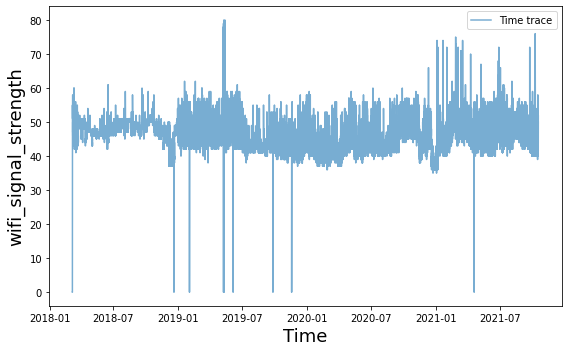

In [9]:
# Variable to plot
col = "wifi_signal_strength"

# Determine if highlighted timestamp exist and should be plotted
plot_highlights = True
if len(df.query("highlight==True")) > 0:
    plot_highlights = False
    
# Plot    
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)

# Save figure
save_fig(f"{col}_{PUMP_ID}")

### Cycles properties

#### Number of performed cycles

Saving figure p1_cycles_1A5008_GW

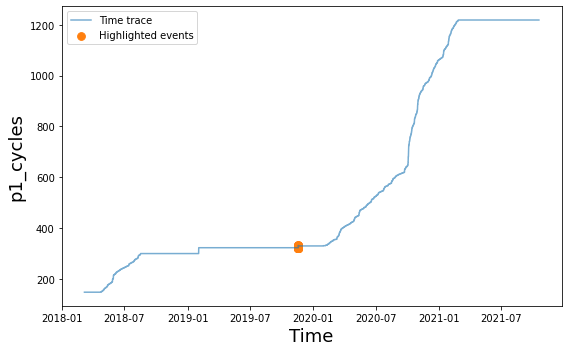

In [10]:
# Unit 1
col = "p1_cycles"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure p2_cycles_1A5008_GW

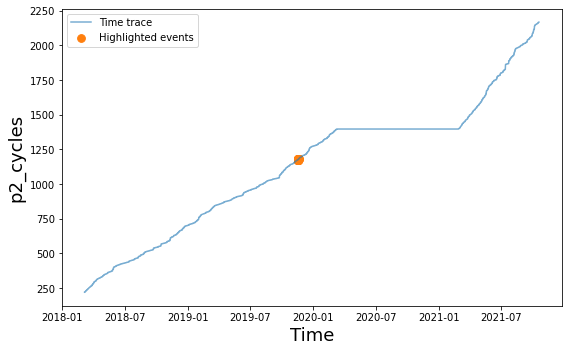

In [11]:
# Unit 2
col = "p2_cycles"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

#### Cycle rate

Saving figure p1_cycleshour_1A5008_GW

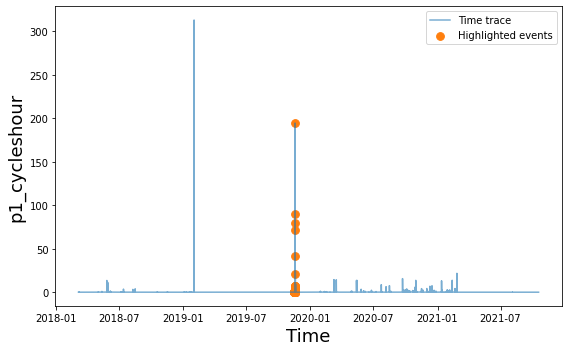

In [12]:
# Unit 1
col = "p1_cycleshour"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure p1_cycleshour_1A5008_GW_zoom

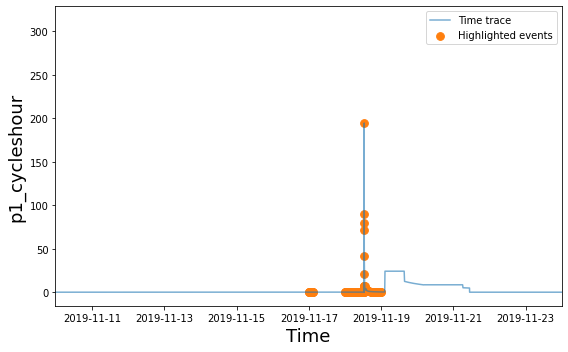

In [13]:
# Zoom into the time range around the first highlighted timestamp
# We plot the time range from 7 days before to 7 days after the timestamp
if len(df.query("highlight==True")) > 0:
    col = "p1_cycleshour"
    fig, ax = plot_single_feature(df, col=col)
    ax.set_xlim(df.query("highlight==True")["real_time"].iloc[0]-pd.Timedelta(7, unit="days"), 
                df.query("highlight==True")["real_time"].iloc[0]+pd.Timedelta(7, unit="days")) 
    save_fig(f"{col}_{PUMP_ID}_zoom")

Saving figure p2_cycleshour_1A5008_GW

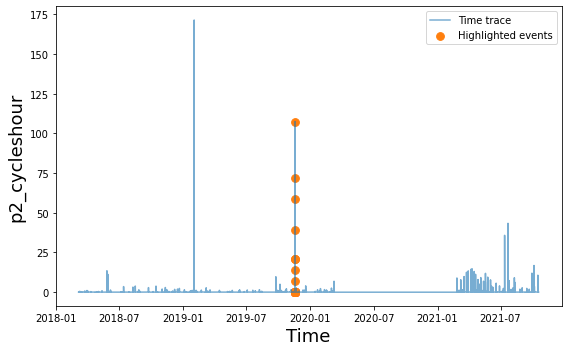

In [14]:
# Unit 2
col = "p2_cycleshour"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure p2_cycleshour_1A5008_GW_zoom

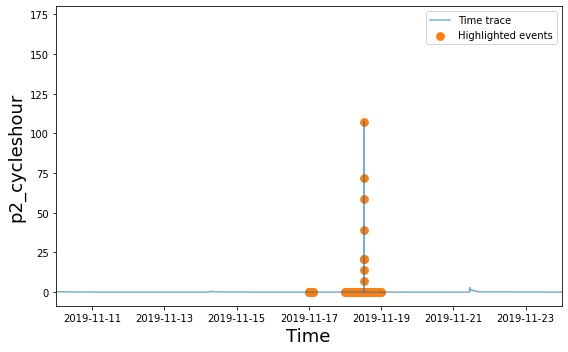

In [15]:
# Zoom into the time range around the first highlighted timestamp
# We plot the time range from 7 days before to 7 days after the timestamp
if len(df.query("highlight==True")) > 0:
    col = "p2_cycleshour"
    fig, ax = plot_single_feature(df, col=col)
    ax.set_xlim(df.query("highlight==True")["real_time"].iloc[0]-pd.Timedelta(7, unit="days"), 
                df.query("highlight==True")["real_time"].iloc[0]+pd.Timedelta(7, unit="days")) 
    save_fig(f"{col}_{PUMP_ID}_zoom")

#### Cycle time

Saving figure p1_cyctime_1A5008_GW

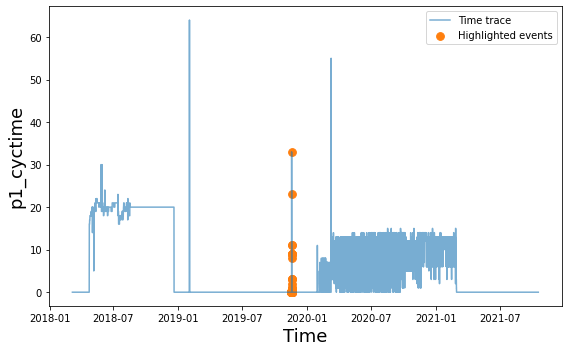

In [16]:
# Unit 1
col = "p1_cyctime"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure p1_cyctime_1A5008_GW_zoom

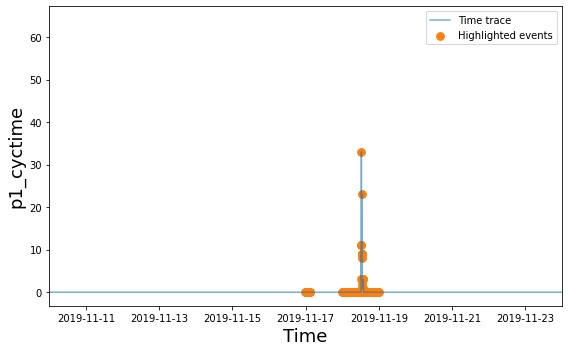

In [17]:
if len(df.query("highlight==True")) > 0:
    col = "p1_cyctime"
    fig, ax = plot_single_feature(df, col=col)
    ax.set_xlim(df.query("highlight==True")["real_time"].iloc[0]-pd.Timedelta(7, unit="days"), 
                df.query("highlight==True")["real_time"].iloc[0]+pd.Timedelta(7, unit="days")) 
    save_fig(f"{col}_{PUMP_ID}_zoom")

In [18]:
# Unit 2
col = "p2_cyctime"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure p2_cyctime_1A5008_GW

In [19]:
if len(df.query("highlight==True")) > 0:
    col = "p2_cyctime"
    fig, ax = plot_single_feature(df, col=col)
    ax.set_xlim(df.query("highlight==True")["real_time"].iloc[0]-pd.Timedelta(7, unit="days"), 
                df.query("highlight==True")["real_time"].iloc[0]+pd.Timedelta(7, unit="days")) 
    save_fig(f"{col}_{PUMP_ID}_zoom")

Saving figure p2_cyctime_1A5008_GW_zoom

### Circuit properties

#### Start current

Saving figure p1_start_cur_1A5008_GW

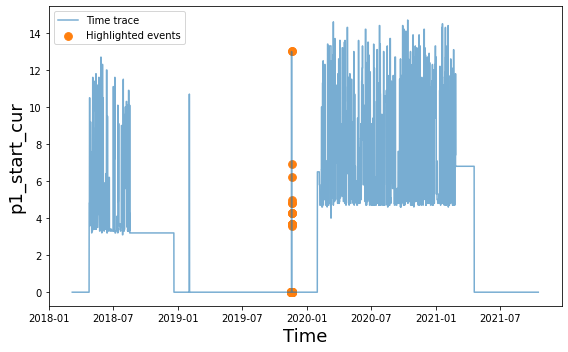

In [20]:
# Unit 1
col = "p1_start_cur"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure p2_start_cur_1A5008_GW

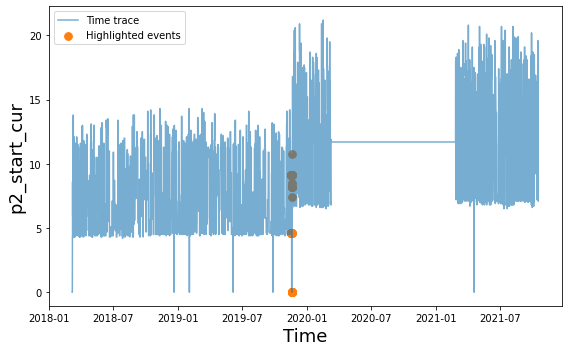

In [21]:
# Unit 2
col = "p2_start_cur"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

#### Steady current

Saving figure p1_steady_cur_1A5008_GW

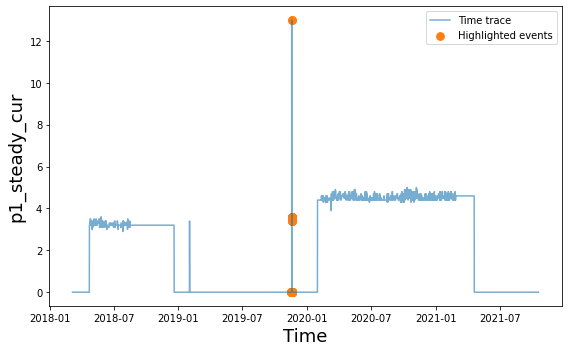

In [22]:
# Unit 1
col = "p1_steady_cur"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure p1_steady_cur_1A5008_GW_zoom

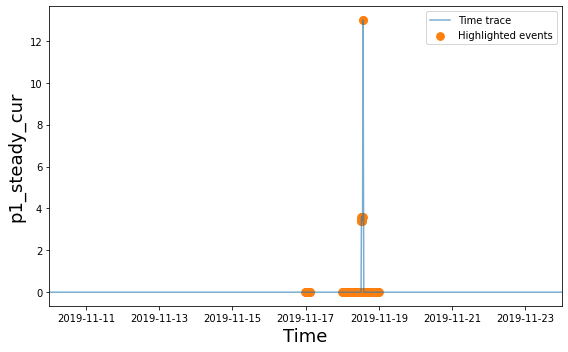

In [23]:
if len(df.query("highlight==True")) > 0:
    col = "p1_steady_cur"
    fig, ax = plot_single_feature(df, col=col)
    ax.set_xlim(df.query("highlight==True")["real_time"].iloc[0]-pd.Timedelta(7, unit="days"), 
                df.query("highlight==True")["real_time"].iloc[0]+pd.Timedelta(7, unit="days")) 
    save_fig(f"{col}_{PUMP_ID}_zoom")

Saving figure p2_steady_cur_1A5008_GW

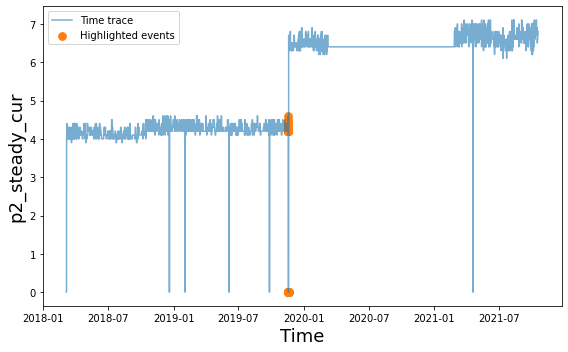

In [24]:
# Unit 2
col = "p2_steady_cur"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure p2_steady_cur_1A5008_GW_zoom

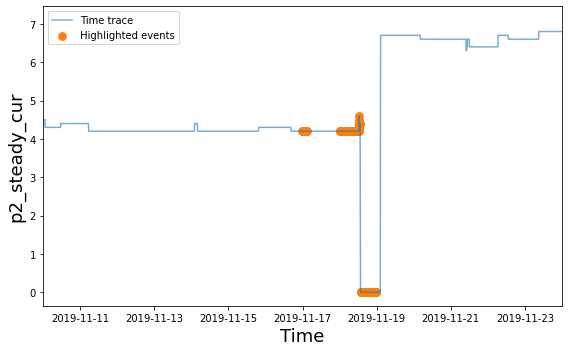

In [25]:
if len(df.query("highlight==True")) > 0:
    col = "p2_steady_cur"
    fig, ax = plot_single_feature(df, col=col)
    ax.set_xlim(df.query("highlight==True")["real_time"].iloc[0]-pd.Timedelta(7, unit="days"), 
                df.query("highlight==True")["real_time"].iloc[0]+pd.Timedelta(7, unit="days")) 
    save_fig(f"{col}_{PUMP_ID}_zoom")

#### Volts

Saving figure p1_volts_1A5008_GW

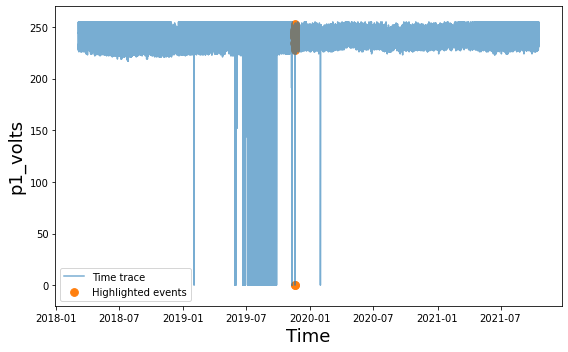

In [26]:
# Unit 1
col = "p1_volts"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
ax.set_ylim(-20, 270) # We fix the scale for ease of comparison with other pumps
save_fig(f"{col}_{PUMP_ID}")

Saving figure p1_volts_1A5008_GW_zoom

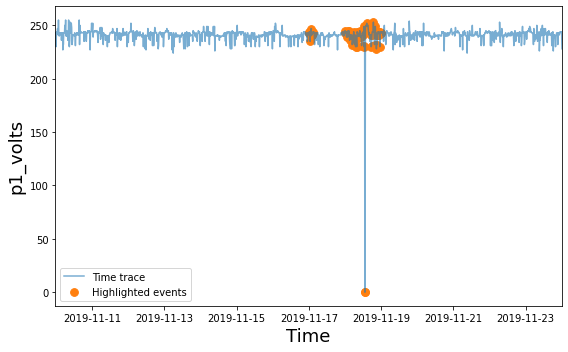

In [27]:
if len(df.query("highlight==True")) > 0:
    col = "p1_volts"
    fig, ax = plot_single_feature(df, col=col)
    ax.set_xlim(df.query("highlight==True")["real_time"].iloc[0]-pd.Timedelta(7, unit="days"), 
                df.query("highlight==True")["real_time"].iloc[0]+pd.Timedelta(7, unit="days")) 
    save_fig(f"{col}_{PUMP_ID}_zoom")

Saving figure p2_volts_1A5008_GW

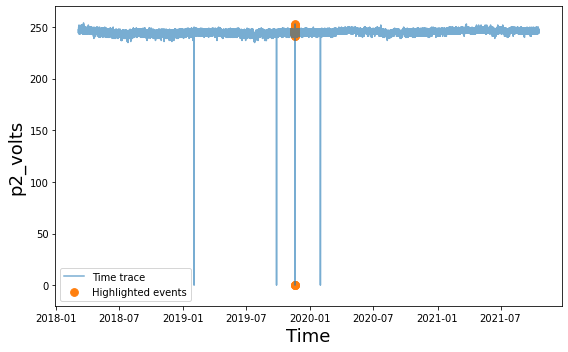

In [28]:
# Unit 2
col = "p2_volts"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
ax.set_ylim(-20, 270) # We fix the scale for ease of comparison with other pumps
save_fig(f"{col}_{PUMP_ID}")

Saving figure p2_volts_1A5008_GW_zoom

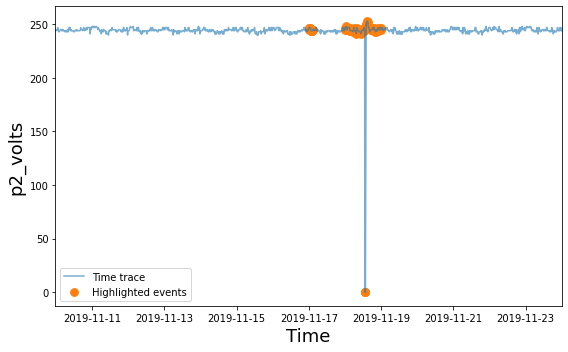

In [29]:
if len(df.query("highlight==True")) > 0:
    col = "p2_volts"
    fig, ax = plot_single_feature(df, col=col)
    ax.set_xlim(df.query("highlight==True")["real_time"].iloc[0]-pd.Timedelta(7, unit="days"), 
                df.query("highlight==True")["real_time"].iloc[0]+pd.Timedelta(7, unit="days")) 
    save_fig(f"{col}_{PUMP_ID}_zoom")

We also plot the voltage for unit 1 together with the wifi strength as a way to highlight possible issues with the remote communication that is reflected in the data.

Saving figure p1_volts_and_wifi_1A5008_GW

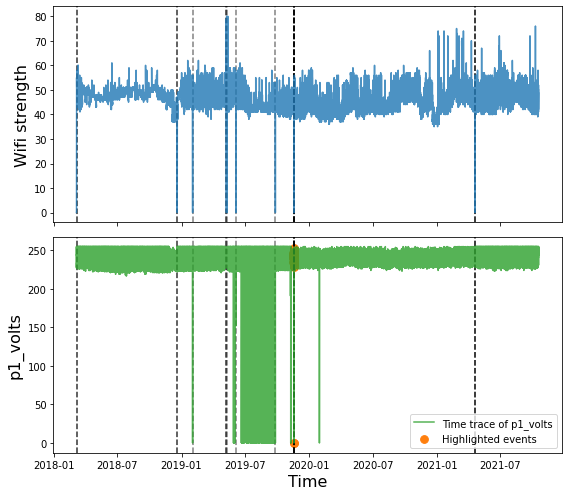

In [30]:
col = "p1_volts"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, axes = plot_single_feature_with_wifi(df, 
                                          col=col, 
                                          plot_highlights=plot_highlights)
save_fig(f"{col}_and_wifi_{PUMP_ID}")

#### Resistance

Saving figure last_meg_p1_1A5008_GW

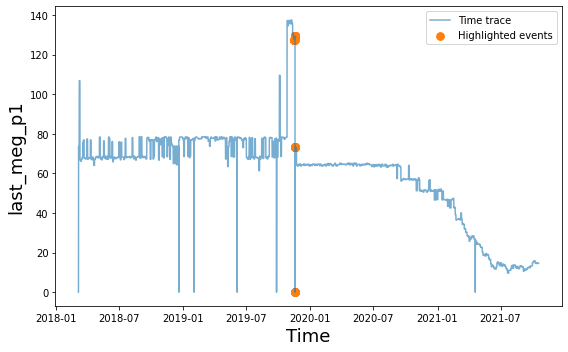

In [31]:
# Unit 1
col = "last_meg_p1"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure last_meg_p1_1A5008_GW_zoom

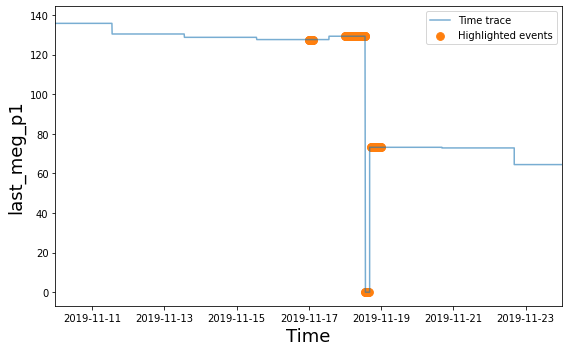

In [32]:
if len(df.query("highlight==True")) > 0:
    col = "last_meg_p1"
    fig, ax = plot_single_feature(df, col=col)
    ax.set_xlim(df.query("highlight==True")["real_time"].iloc[0]-pd.Timedelta(7, unit="days"), 
                df.query("highlight==True")["real_time"].iloc[0]+pd.Timedelta(7, unit="days")) 
    save_fig(f"{col}_{PUMP_ID}_zoom")

Saving figure last_meg_p2_1A5008_GW

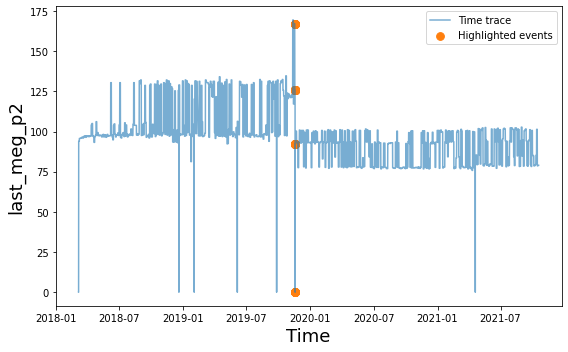

In [33]:
# Unit 2
col = "last_meg_p2"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

In [34]:
if len(df.query("highlight==True")) > 0:
    col = "last_meg_p2"
    fig, ax = plot_single_feature(df, col=col)
    ax.set_xlim(df.query("highlight==True")["real_time"].iloc[0]-pd.Timedelta(7, unit="days"), 
                df.query("highlight==True")["real_time"].iloc[0]+pd.Timedelta(7, unit="days")) 
    save_fig(f"{col}_{PUMP_ID}_zoom")

Saving figure last_meg_p2_1A5008_GW_zoom

As above, we plot the resistance for unit 1 together with the wifi strength as a way to highlight possible issues with the remote communication that is reflected in the data.

Saving figure last_meg_p1_and_wifi_1A5008_GW

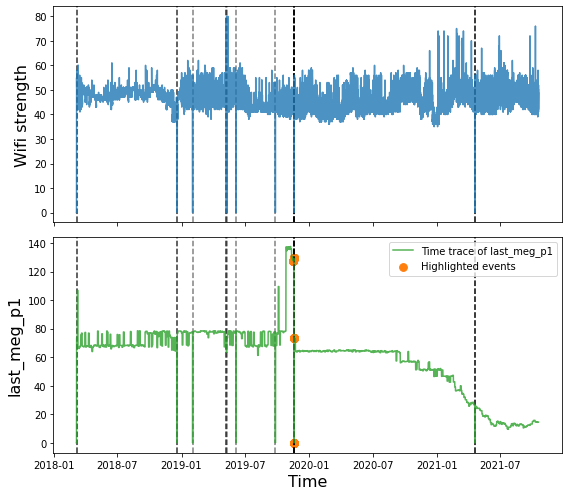

In [35]:
col = "last_meg_p1"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, axes = plot_single_feature_with_wifi(df,
                                          col=col,
                                          plot_highlights=plot_highlights)
save_fig(f"{col}_and_wifi_{PUMP_ID}")

### Float

In [36]:
# Unit 1 
col = "float_1"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure float_1_1A5008_GW

### Temperature

In [37]:
col = "temp_unit"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure temp_unit_1A5008_GW

### Battery properties

Saving figure battery_volt_1A5008_GW

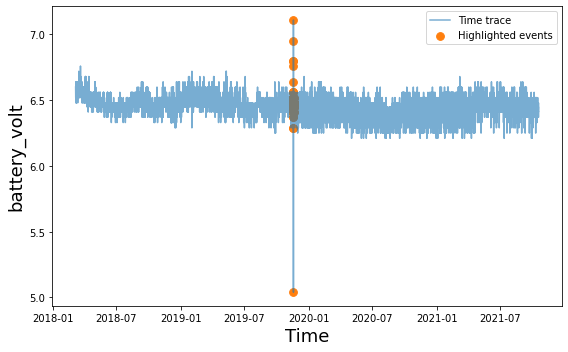

In [38]:
col = "battery_volt"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure pmx_1_sw_1A5008_GW

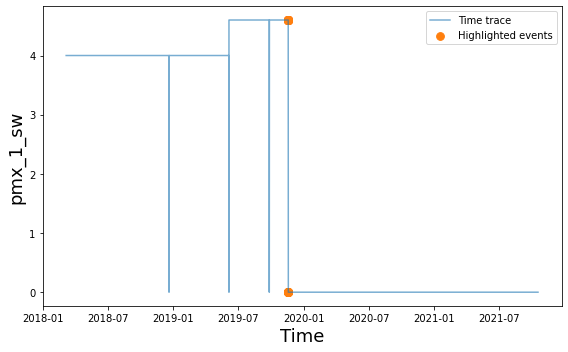

In [39]:
col = "pmx_1_sw"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure pmx_1_volt_1A5008_GW

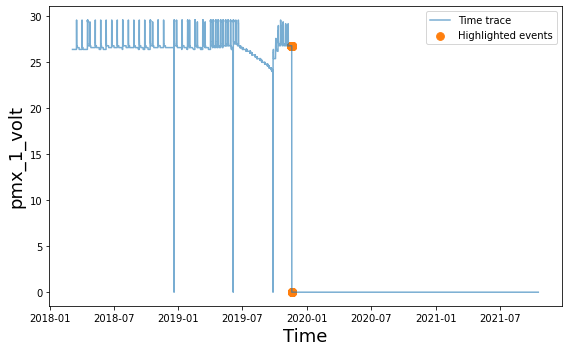

In [40]:
col = "pmx_1_volt"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure pmx_1_batt_pct_1A5008_GW

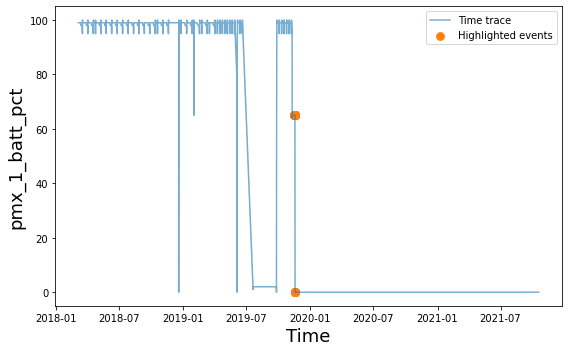

In [41]:
col = "pmx_1_batt_pct"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Comparison with wifi signal strength.

Saving figure pmx_1_batt_pct_and_wifi_1A5008_GW

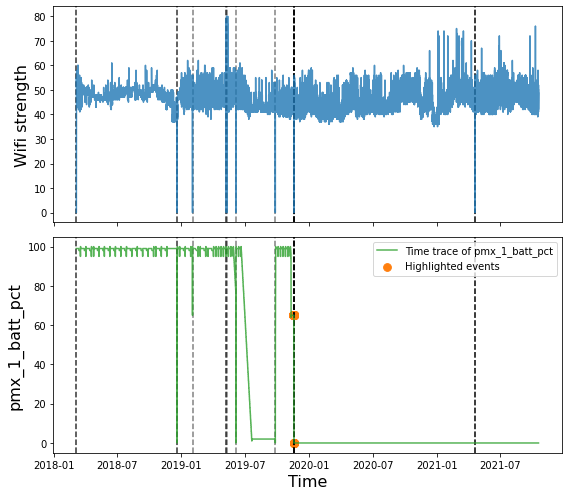

In [42]:
col = "pmx_1_batt_pct"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, axes = plot_single_feature_with_wifi(df,
                                          col=col,
                                          plot_highlights=plot_highlights)
save_fig(f"{col}_and_wifi_{PUMP_ID}")

Saving figure pmx_1_batt_age_1A5008_GW

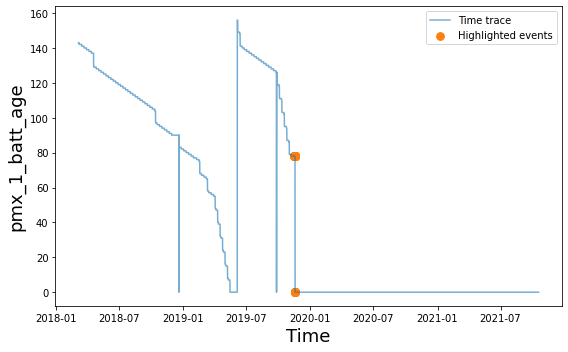

In [43]:
col = "pmx_1_batt_age"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure pmx_1_err_1A5008_GW

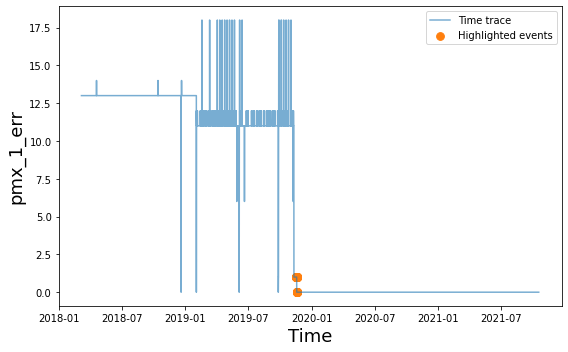

In [44]:
col = "pmx_1_err"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure pmx_1_src_1A5008_GW

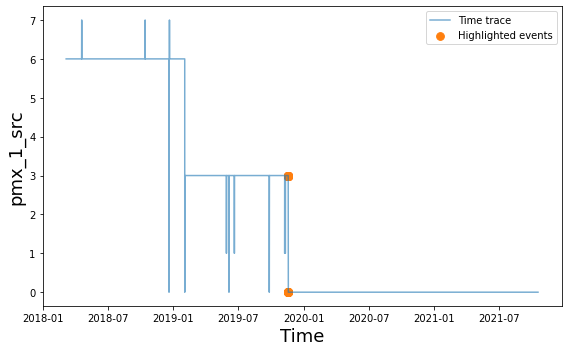

In [45]:
col = "pmx_1_src"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

In [46]:
col = "pmx_1_charge_time"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure pmx_1_charge_time_1A5008_GW

In [47]:
col = "pmx_1_backup_time"
plot_highlights = False
if len(df.query("highlight==True")) > 0:
    plot_highlights = True
fig, ax = plot_single_feature(df, col=col, plot_highlights=plot_highlights)
save_fig(f"{col}_{PUMP_ID}")

Saving figure pmx_1_backup_time_1A5008_GW